# Beamline 8.3.2 Reconstruction

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import sys
import os
import multiprocessing as mp
os.environ['NUMEXPR_MAX_THREADS'] = str(mp.cpu_count()) # to avoid numexpr warning
os.environ['TOMOPY_PYTHON_THREADS'] = str(mp.cpu_count()) # to avoid numexpr warning
import time
import numexpr
import numpy as np
from skimage import transform, filters, io
import tomopy
import svmbir
import dxchange
import matplotlib.pyplot as plt
import ipywidgets as widgets
from pathlib import Path
from ipywidgets import interact, fixed, FloatSlider, IntSlider
import ALS_recon_functions as als
import ALS_recon_helper as helper
import copy
import pandas as pd
import base64
import pickle
from ipyfilechooser import FileChooser

use_gpu = als.check_for_gpu()

astropy module not found
olefile module not found


## Choose Data

In [2]:
dataDir = "/global/cfs/cdirs/als/users/tomography_notebooks/example_data" # where is the raw data
file_chooser = FileChooser(dataDir)
file_chooser.filter_pattern = '*.h5' # only show .h5 files
file_chooser.title = f'Choose data file'
display(file_chooser)

FileChooser(path='/global/cfs/cdirs/als/users/tomography_notebooks/example_data', filename='', title='Choose d…

## Find Center of Rotation (COR)
##### Check COR by manually aligning 0 and 180 degree projections

20180426_125539_feather1_x00y01-006.h5:
numslices: 2160, rays: 2560, numangles: 1969
angularrange: 180.000043, \pxsize: 0.6269999999999999 um, distance: 0 mm. energy: 0.0 keV


Output()

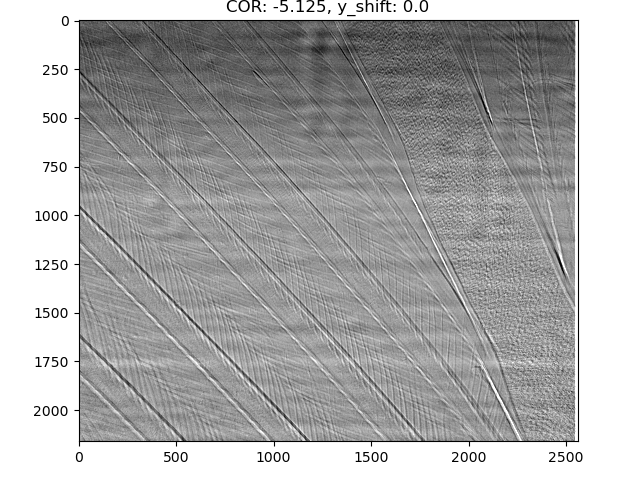

In [3]:
if file_chooser.selected is None:
    print("No datafile selected. Click Select to choose a datafile")
    sys.exit()
metadata = als.read_metadata(file_chooser.selected, print_flag = True)
tomo, _ = als.read_data(file_chooser.selected, proj=slice(0,None,metadata['numangles']-1), downsample_factor=None, prelog=True)
cor_init = als.auto_find_cor(file_chooser.selected) # cross-correlation based COR estimate
first_proj, last_proj_flipped = tomo[0], np.fliplr(tomo[-1])

axs, img, cor_sliders, cor_out = als.plot_0_and_180_proj_diff(first_proj,
                                                              last_proj_flipped,
                                                              init_cor=-2*cor_init,
                                                              # yshift=True,
                                                              fignum=0)
                                                            
display(cor_sliders,cor_out)

### Unfold cell below for description of parameters

#### 1. Alignment
* **COR:**
Initializes to value found above, but can fine tune if desred. With mismatched COR, arc/shadow artifacts appear in image. Adjust COR to minimize artifacts.

#### 2. Resolution
*Note: On NERSC, reconstruction takes ~2-4 sec/slice with GPU, ~30 sec/slice on CPU at full resolution (1313 ang x 2560 rays).*

* **Angle Downsampling:**
Downsampling angles by 2x reduces reconstruction time by ~2x, but may introduce streaks through center.

* **Projection Downsampling:**
Downsampling projections by 2x reduces spatial resolution by 2x, reconstruction time by ~4x (minus loading time).

#### 3. Ring Removal
*Note: strong stripe removal takes time, can reduce resolution and sometimes even introduce artifacts too, so only use as much as you need to remove visible rings

* **Small Ring Size:**
Window size of the median filter to remove small stripes. Larger is stronger but takes longer. Set to appx width of small stripes. Always choose odd value, set to 1 to turn off.

* **Large Ring Size:**
Window size of the median filter to remove large stripes. Set to appx width of large stripes -- should be larger value than Small Ring Size. Always choose odd value, set to 1 to turn off.

* **Ring Removal SNR:**
Sensitivity of large stripe detection method. Smaller is more sensitive. No affect on small stripes. Recommended values: 1.1 -- 3.0.

## Run Following Cell to Generate an Interface to Adjust Reconstruction Parameters

Box(children=(VBox(children=(HTML(value='<b><font size=3>Official Recon</b>', layout=Layout(justify_content='c…

Output()

Output()

interactive(children=(FloatRangeSlider(value=(-0.0013086814503185452, 0.0013323670055251557), description='Col…

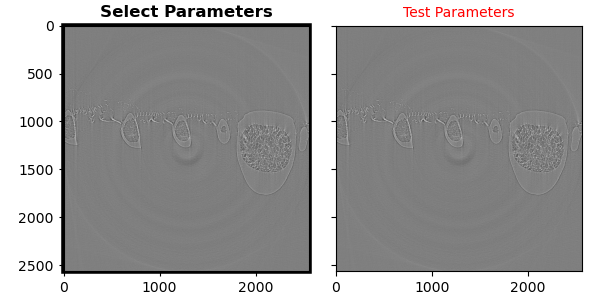

interactive(children=(IntSlider(value=0, description='Projection', layout=Layout(width='50%'), max=1968), Outp…

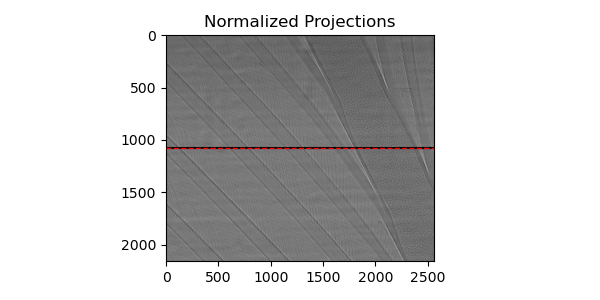

In [4]:
plt.ioff() # turn off matplotlib interactive mode -- plots wont immediately display, so can control order better
# Initial recon needed to get size/colorscale of plots
tomo, angles = als.read_data(file_chooser.selected,
                             proj=slice(0,-1,8),
                             sino=slice(metadata["numslices"]//2,metadata["numslices"]//2+1,1),
                             downsample_factor=1)
cor = -cor_sliders.children[0].value/2
recon_init = als.astra_fbp_recon(tomo, angles, COR=cor, fc=1, gpu=use_gpu).squeeze()
clim_init = [np.percentile(recon_init,1),np.percentile(recon_init,99)]

# Reconstructions figures
if plt.fignum_exists(1): plt.close(1)
recon_comparison_fig, recon_comparison_axs = plt.subplots(1,2,num=1,figsize=(6,3),sharex=True,sharey=True)
recon_comparison_img = [None, None]
recon_comparison_img[0] = recon_comparison_axs[0].imshow(recon_init,cmap='gray')
recon_comparison_axs[0].set_title('Select Parameters',fontweight="bold")
recon_comparison_axs[0].patch.set_edgecolor('black')  
recon_comparison_axs[0].patch.set_linewidth(4)  
recon_comparison_img[1] = recon_comparison_axs[1].imshow(recon_init,cmap='gray')
recon_comparison_axs[1].set_title('Test Parameters',color='r', fontsize=10)
plt.tight_layout()

# Projections figures
if plt.fignum_exists(2): plt.close(2)
proj_fig, proj_axs = plt.subplots(1,1,num=2,figsize=(6,3),sharex=True,sharey=True)
proj_img = proj_axs.imshow(first_proj,cmap='gray')
hline_handles = [None, None]
hline_handles[0] = proj_axs.axhline(y=0,color='k',linestyle='-')
hline_handles[1] = proj_axs.axhline(y=0,color='r',linestyle='--',linewidth=1)
proj_axs.set_title('Normalized Projections')
plt.tight_layout()


recon_parameter_widgets, recon_parameters_tab, recon_output = helper.reconstruction_parameter_options(file_chooser.selected,
                                                                                                   metadata,
                                                                                                   cor,
                                                                                                   use_gpu,
                                                                                                   recon_comparison_img[0],
                                                                                                   hline_handles[0])
comparison_parameter_widgets, comparison_parameters_tab, comparison_output = helper.reconstruction_parameter_options(file_chooser.selected,
                                                                                                   metadata,
                                                                                                   cor,
                                                                                                   use_gpu,
                                                                                                   recon_comparison_img[1],
                                                                                                   hline_handles[1])

clim_slider = widgets.interactive(als.set_clim, img=widgets.fixed(recon_comparison_img),
                              clims=widgets.FloatRangeSlider(description='Color Scale', layout=widgets.Layout(width='50%'),
                                                                   min=recon_init.min(), max=recon_init.max(),
                                                                   step=(recon_init.max()-recon_init.min())/500, value=clim_init,
                                                                   readout=True, readout_format='.2e'))
proj_slider = widgets.interactive(als.set_proj, path=widgets.fixed(file_chooser.selected), img=widgets.fixed(proj_img),
                              proj_num=widgets.IntSlider(description='Projection', layout=widgets.Layout(width='50%'),
                                                                   min=0, max=metadata["numangles"]-1,
                                                                   step=1, value=0))

# Haven't played around with layout too much. This part could probably be much fancier
recon_header_widget = widgets.HTML(value=f"<b><font size=3>Official Recon</b>",layout=widgets.Layout(justify_content="center"))
comparison_header_widget = widgets.HTML(value=f"<b><font size=3>Comparison</b>",layout=widgets.Layout(justify_content="center"))

box_layout = widgets.Layout(width='100%',
                            height='100%',
                            margin='0,1%,0,1%'
                           )
box = widgets.Box(children=[widgets.VBox([recon_header_widget,recon_parameters_tab]),
                            widgets.VBox([comparison_header_widget,comparison_parameters_tab])]
                            ,layout=box_layout)

# Display
display(box, recon_output, comparison_output) # show recon parameter widgets
display(clim_slider) # show color scale widget
recon_comparison_fig.show() # show recon figure
display(proj_slider) # show projection widget
proj_fig.show() # show projection figure
plt.ion() # turn matplotlib interactive mode back on

### Choose Number of Slices to Reconstruct and Location to Save Images

In [5]:
save_file_chooser = FileChooser(als.get_scratch_path())
save_file_chooser.show_only_dirs = True
save_file_chooser.title = f'Choose where to save reconstruction'

slices_header_widget = widgets.Label(value="Choose which slices to reconstruct",layout=widgets.Layout(justify_content="center"))

start_slice_widget = widgets.BoundedIntText(description='Start Slice',
                                min=0,
                                max=metadata['numslices']-1,
                                step=1,
                                value=0,
    style={'description_width': 'initial'} # this makes sure description text doesn't get cut off
)
stop_slice_widget = widgets.BoundedIntText(description='Stop Slice',
                                min=0,
                                max=metadata['numslices']-1,
                                step=1,
                                value=metadata['numslices']-1,
    style={'description_width': 'initial'} # this makes sure description text doesn't get cut off
)
slices_box = widgets.VBox([slices_header_widget,start_slice_widget,stop_slice_widget])
display(save_file_chooser)
display(slices_box)

FileChooser(path='/global/cscratch1/sd/dperl', filename='', title='Choose where to save reconstruction', show_…

### Populate Parameters of Reconstruction with "Selected Parameters"

In [6]:
data_settings = {
    "output_path": save_file_chooser.selected_path, # existing folder where you can write lots of data
    "data_path": file_chooser.selected, # don't change
    "name": os.path.splitext(file_chooser.selected_filename)[0], # don't change
    "start_slice": start_slice_widget.value,
    "stop_slice": stop_slice_widget.value,
    "angles_ind": slice(0,-1,recon_parameter_widgets['angle_downsample'].value), # use every angle 
    "proj_downsample": recon_parameter_widgets['proj_downsample'].value,
}

preprocess_settings = {
    "snr": recon_parameter_widgets['ring']['sarepy_snr'].value, 
    "la_size": recon_parameter_widgets['ring']['sarepy_large'].value,
    "sm_size": recon_parameter_widgets['ring']['sarepy_small'].value,
    "outlier_diff_1D": recon_parameter_widgets['additional']['outlier_diff'].value,
    "outlier_sizef_1D": recon_parameter_widgets['additional']['outlier_size'].value,
    "minimum_transmission": recon_parameter_widgets['additional']['min_transmission'].value
}

postprocess_settings = {
    "ringSigma": recon_parameter_widgets['ring']['ringSigma'].value,
    "ringLevel": recon_parameter_widgets['ring']['ringLevel'].value
}

recon_settings = {
    "COR": recon_parameter_widgets['cor'].value,
    "fc": recon_parameter_widgets['fc'].value, 
    "use_gpu": use_gpu
}

settings = {"data": data_settings, "preprocess": preprocess_settings, "postprocess": postprocess_settings, "recon": recon_settings}
for subset in settings:
   print('\n' + subset.upper())
   for key in settings[subset]:
       print(f"{key}: {settings[subset][key]}")


DATA
output_path: /global/cscratch1/sd/dperl/tomo_data/test
data_path: /global/cfs/cdirs/als/users/tomography_notebooks/example_data/20180426_125539_feather1_x00y01-006.h5
name: 20180426_125539_feather1_x00y01-006
start_slice: 0
stop_slice: 2159
angles_ind: slice(0, -1, 8)
proj_downsample: 8

PREPROCESS
snr: 3
la_size: 1
sm_size: 11
outlier_diff_1D: 0.0
outlier_sizef_1D: 1
minimum_transmission: 0.0

POSTPROCESS
ringSigma: 0.0
ringLevel: 0

RECON
COR: -5.125
fc: 1.0
use_gpu: True


## Reconstruct 3D Volume

### Reconstruct and save in notebook
###### Perlmutter Exclusive GPU node can reconstruct 100 slices in ~10-30 sec. On Exclusive CPU node it's ??? sec
##### *Note: For more efficient workflow, submit reconstruction to NERSC batch job (see below)*

In [7]:
nchunk = 50 # Balance between available cpus and memory (larger value can be more parallelized but uses more memory). 50 was empirically chosen on Perlmutter exclusive node, though 100 was more or less the same.
save_dir = os.path.join(settings["data"]["output_path"],settings["data"]["name"])
if not os.path.exists(save_dir): os.makedirs(save_dir)
save_name = os.path.join(save_dir,"img")
for i in range(np.ceil((settings["data"]['stop_slice']-settings["data"]['start_slice'])/nchunk).astype(int)):
    start_iter = settings["data"]['start_slice']+i*nchunk
    stop_iter = np.minimum(start_iter+nchunk,settings["data"]['stop_slice'])
    print(f"Starting recon of slices {start_iter}-{stop_iter}...",end=' ')
    tic = time.time()

    recon = helper.default_reconstruction(path=settings["data"]["data_path"],
                           angles_ind=settings["data"]['angles_ind'],
                           slices_ind=slice(start_iter,stop_iter,1),
                           proj_downsample=settings["data"]["proj_downsample"],
                           COR=settings["recon"]["COR"],
                           fc=settings["recon"]["fc"],
                           preprocessing_args=settings["preprocess"],
                           postprocessing_args=settings["postprocess"],
                           use_gpu=settings["recon"]["use_gpu"])

    print(f"Finished: took {time.time()-tic} sec. Saving files...")
    dxchange.write_tiff_stack(recon, fname=save_name, start=start_iter)
print("Done")

Starting recon of slices 0-50... Finished: took 9.40501070022583 sec. Saving files...
Starting recon of slices 50-100... Finished: took 9.33068323135376 sec. Saving files...
Starting recon of slices 100-150... 

KeyboardInterrupt: 

### Reconstruct and save with NERSC batch job
##### 1. The cell below prepares the config script needed to submit a job

In [ ]:
import batch_recon

with open (als.get_batch_template(), "r") as t:
    template = t.read()
    
configs_dir = Path(os.path.join(settings["data"]["output_path"],"configs/"))
if not configs_dir.exists():
    os.mkdir(configs_dir)

config_script_name = os.path.join(configs_dir,"config_"+settings["data"]["name"]+".sh")    
enc = batch_recon.dictionary_prep(settings)
with open(config_script_name, 'w') as f:
    script = template
    script += "\n"
    script += "cd " + os.getcwd()
    script += "\n"
    script += "shifter python batch_recon.py"
    script += " '" + enc + "'"
    f.write(script)
    f.close()
    
# list configsDir
print(f"Contents of batch jobs configs directory: {configs_dir}") 
os.system(f"ls {configs_dir}")
print('')

##### 2. Run the following cell to submit the batch job (can't submit when using entrypoint) 

In [ ]:
# submit batch job config you just created
os.system(f"sbatch {os.path.join(configs_dir,config_script_name)}")
# see all current batch jobs (including this interavtive jupyter session)
print("List of current batch jobs:")
os.system("sqs")

##### To cancel a batch job, run this cell with the right Job ID

In [ ]:
# eq. scancel 2800193
os.system("scancel 0000000")

### Alternatively, you can submit all job scripts in a folder at once using helper bash script
##### 1. Modify first line of submit_all_jobs_template.sh with your configs directory (from cell below)
##### 2. Save as new bash script (eg. my_submit_all_jobs.sh)
##### 3. In terminal, `source [bash script name]`

In [ ]:
#Please use this to change out the filepath in the 
#bash script (the helper script to loop and submit all configs).
print(str(configs_dir.absolute())+"/*")

## Optional: SVMBIR reconstruction (for better image quality)
##### Note: SVMBIR is MUCH slower. At full resolution (1313 ang x 2560 rays), takes ~2-4 min/slice with all 128 exclusive node threads (uses CPU only). Downsampling by 2x reduces time by ~4x

### Unfold cell below for description of SVMBIR parameters

**p**: smoothing parameter for large grayscale differences (ie contrasting pixels).
<br> 1 = Total Variation: preserves edges but can look unrealistic ("cartoonish")
<br> 2 = Tikhonov regularization: looks natural but reduces resolution
<br> Typically a compromise between 1 and 2 works best

**q**: smoothing parameter for small grayscale differences (ie. similar pixels). Between p and 2

**T**: transition value from q to p (in pixel grayscale difference). Must be > 0

**sharpness**: strength of smoothing -- lower is more smooth. +1 change is equivalent to +6 dB snr. Can typically just change one or the other

**snr_dB**: strength of smoothing -- lower is more smooth. +6 dB is equivalent to +1 sharpness. Can typically just change one or the other

In [8]:
svmbir_header_widget = widgets.Label(value="Choose SVMBIR parameters",layout=widgets.Layout(justify_content="center"))
blank_widget = widgets.Label(value="",layout=widgets.Layout(justify_content="center"))
p_widget = widgets.BoundedFloatText(description='p',
                                min=1,
                                max=2,
                                step=0.01,
                                value=1.2,
    style={'description_width': 'initial'} # this makes sure description text doesn't get cut off
)
q_widget = widgets.BoundedFloatText(description='q',
                                min=1,
                                max=2,
                                step=0.01,
                                value=2,
    style={'description_width': 'initial'} # this makes sure description text doesn't get cut off
)
T_widget = widgets.BoundedFloatText(description='T',
                                min=0.01,
                                max=10,
                                step=0.01,
                                value=0.1,
    style={'description_width': 'initial'} # this makes sure description text doesn't get cut off
)
sharpness_widget = widgets.BoundedFloatText(description='sharpness',
                                min=-10,
                                max=10,
                                step=0.1,
                                value=0,
    style={'description_width': 'initial'} # this makes sure description text doesn't get cut off
)
snr_dB_widget = widgets.BoundedFloatText(description='snr_dB',
                                min=0,
                                max=80,
                                step=1,
                                value=40,
    style={'description_width': 'initial'} # this makes sure description text doesn't get cut off
)
svmbir_slice_widget = widgets.BoundedIntText(description='Slice number',
                                min=0,
                                max=metadata['numslices']-1,
                                step=1,
                                value=metadata['numslices']//2,
    style={'description_width': 'initial'} # this makes sure description text doesn't get cut off
)

svmbir_box = widgets.HBox([
                        widgets.VBox([svmbir_slice_widget, svmbir_header_widget,p_widget,q_widget]),
                        widgets.VBox([blank_widget, blank_widget,T_widget,sharpness_widget,snr_dB_widget])
])
display(svmbir_box)

In [9]:
%%time
slices_ind = slice(svmbir_slice_widget.value,svmbir_slice_widget.value+1,1)

tic = time.time()

tomo, angles = als.read_data(settings["data"]["data_path"],
                             proj=settings["data"]["angles_ind"],
                             sino=slices_ind,
                             downsample_factor=settings["data"]["proj_downsample"],
                             args=settings["preprocess"])

astra_recon = als.astra_fbp_recon(tomo, angles,
                                  COR=settings["recon"]["COR"]/settings["data"]["proj_downsample"],
                                  fc=settings["recon"]["fc"],
                                  gpu=settings["recon"]["use_gpu"]
                                  )

print(f"Finished Astra recon, took {time.time()-tic} sec. Starting SVBMIR...")

settings["svmbir_settings"] = {
    "p": p_widget.value, 
    "q": q_widget.value, 
    "T": T_widget.value,
    "sharpness": sharpness_widget.value, 
    "snr_dB": snr_dB_widget.value,
    "max_iter": 100,
    "COR": settings['recon']['COR']/settings["data"]["proj_downsample"]
}

tic = time.time()

tomo, angles = als.read_data(settings["data"]["data_path"],
                             proj=settings["data"]["angles_ind"],
                             sino=slices_ind,
                             downsample_factor=settings["data"]["proj_downsample"],
                             args=settings["preprocess"])

svmbir_recon = als.svmbir_recon(tomo,angles,**settings["svmbir_settings"])
print(f"Finished SVMBIR recon, took {time.time()-tic} sec")
print('')
print('This took:')

Finished Astra recon, took 0.3719050884246826 sec. Starting SVBMIR...
Reconstructing axial size (rows,cols)=(320,320).
Found system matrix: //global/cfs/cdirs/als/users/tomography_notebooks/svmbir_cache/sysmatrix/e88b0b6c90aa60628ea4.2Dsvmatrix
Finished SVMBIR recon, took 6.196413278579712 sec

This took:
CPU times: user 37.8 s, sys: 19.8 s, total: 57.6 s
Wall time: 6.57 s


interactive(children=(FloatRangeSlider(value=(-0.00015799628046806903, 0.00018759591403067941), description='C…

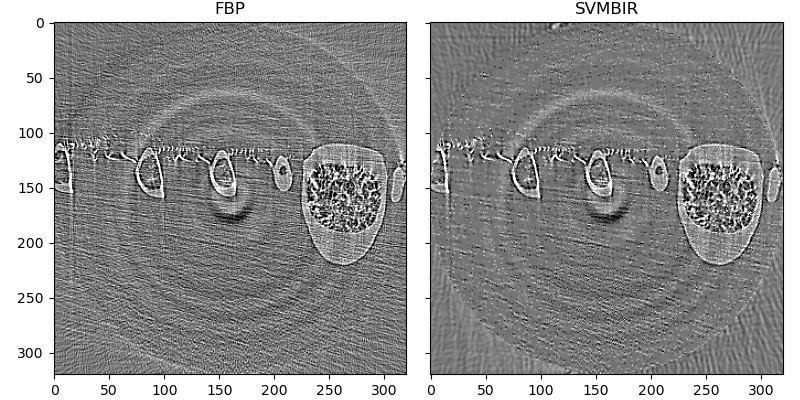

In [10]:
img, axs, clim_slider = als.plot_recon_comparison(astra_recon, svmbir_recon, titles=['FBP','SVMBIR'], fignum=5, figsize=4)
display(clim_slider)

#### Create SVMBIR batch job config script

In [ ]:
import batch_recon

with open (als.get_batch_template("svmbir"), "r") as t:
    template = t.read()

s = os.popen("echo $NERSC_HOST")
out = s.read()
N = 40 if 'cori' in out else 10
    
configs_dir = Path(os.path.join(settings["data"]["output_path"],"configs/"))
if not configs_dir.exists():
    os.mkdir(configs_dir)

config_script_name = os.path.join(configs_dir,"config_"+settings["data"]["name"]+".sh")    
enc = batch_recon.dictionary_prep(settings)
with open(config_script_name, 'w') as f:
    script = template
    script += "\n"
    script += "cd " + os.getcwd()
    script += "\n"
    script += f"srun -N {N} -n 1280 python batch_recon.py"
    script += " '" + enc + "'"
    f.write(script)
    f.close()
    
# list configsDir
print(f"Contents of batch jobs configs directory: {configs_dir}") 
os.system(f"ls {configs_dir}")
print('')